**Recurrent Neural Network (RNN)**

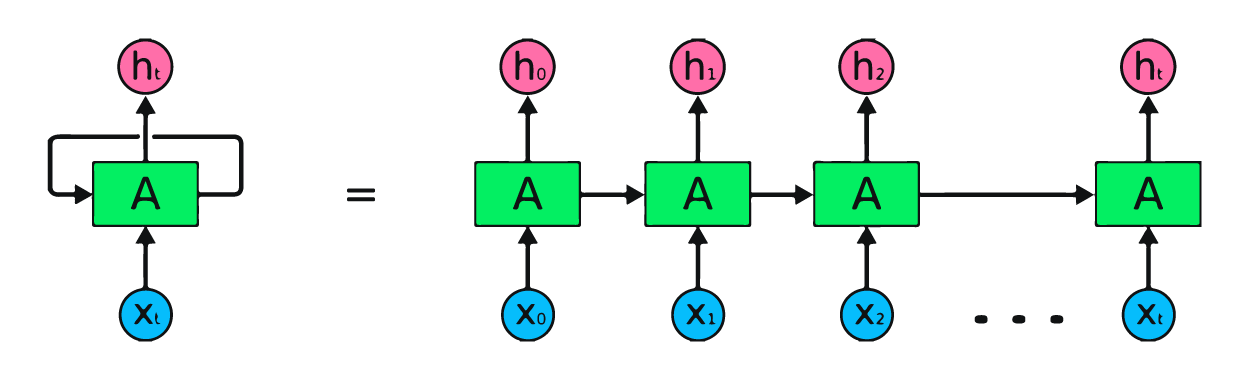


Types of RNN:

1. one to one
2. one to many
3. Many to one
4. Many to Many
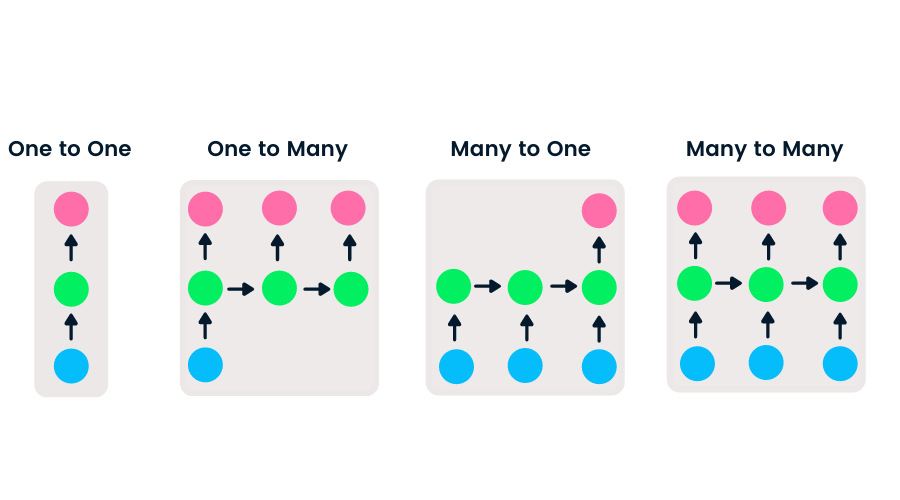

CNN vs RNN:

1. CNN - Image |  RNN - timeseries, text data
2. Simple Backpropagation | RNN Backpropagation , feedforward propagation
3. CNN finite the input output | RNN no restriction on input & output  
4. CNN using video & image | RNN - Speech & text

RNN - Varient:
1. LSTM
2. BiLSTM
3. GRU



In [1]:
#import lib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, GRU, Bidirectional

from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [3]:
dataset = pd.read_csv('/content/Mastercard_stock_history.csv', index_col = "Date", parse_dates = ["Date"]).drop(['Dividends','Stock Splits'], axis = 1)

dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000


In [4]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [5]:
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

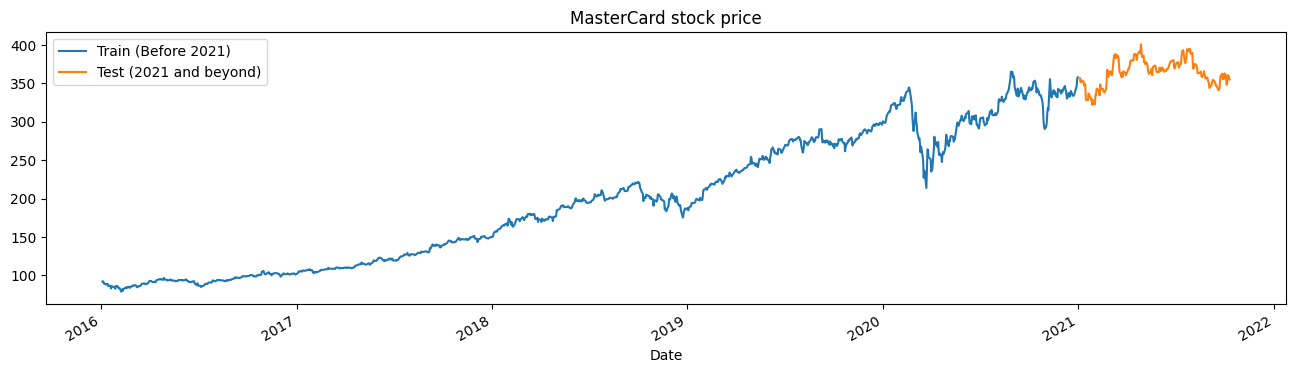

In [7]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
  dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
  dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
  plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
  plt.title("MasterCard stock price")
  plt.show()

train_test_plot(dataset, tstart, tend)

In [8]:
# split

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)


In [9]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [10]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [11]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


In [12]:
# LSTM Model

model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 5s 61ms/step - loss: 0.0167
Epoch 2/50
38/38 [==============================] - 5s 133ms/step - loss: 0.0027
Epoch 3/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0023
Epoch 4/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0020
Epoch 5/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0015
Epoch 6/50
38/38 [==============================] - 3s 88ms/step - loss: 0.0016
Epoch 7/50
38/38 [==============================] - 2s 64ms/step - loss: 0.0010
Epoch 8/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0011
Epoch 10/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0011
Epoch 11/50
38/38 [==============================] - 3s 90ms/step - loss: 8.0932e-04
Epoch 12/50
38/38 [==============================] - 2s 61ms/step - loss: 9.4677e-04
Epoch 13/50
38/38 [=========

In [14]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


7/7 [==============================] - 2s 21ms/step


In [15]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


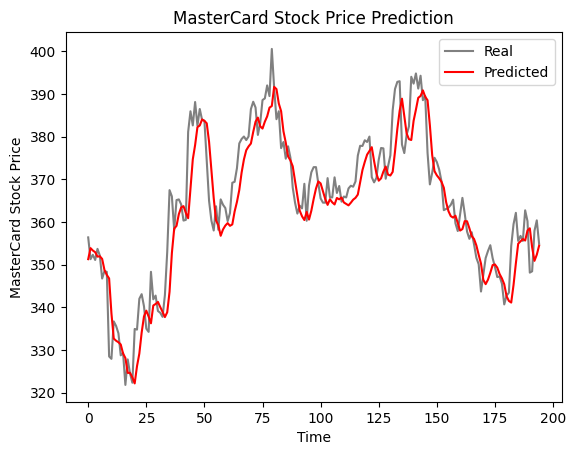

In [16]:
plot_predictions(test_set,predicted_stock_price)